In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nepal-daily-climate-1981-2019:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4264475%2F7344205%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240502%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240502T062822Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2cdbe64f369e63a30deccd5a95522eae8d709480eda771e4c026d2e7e006fef370786a440600992f377015c4731cc43fc86d3b98d055a3868a749413b391db788c870415e05af609c73312bb6b309937aa5655e315b13273262c042071a529516e8ef28f876605f3180bb17240a1b7a5925e5793702b10caed77ff7b3ff6c03c8e00040187b94302dd691bf635c7163591a6142a17fcefe8b5efce176b789cc6332beb2edb7e1420b32978392d77a741e0b8cb87c606258a78f48c4dfa2769b6f0cfe53bdba8d1e72269a03cc377d2fcf91fa3baed5d17aefc0bf57e21c4e1c7fa26d452e3f53e3aba11bc254bf0ea3cb9a368a17f613537cf537b12d4c2ace9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 37907417 bytes downloaded
Downloaded and uncompressed: nepal-daily-climate-1981-2019
Data source import complete.


### Importing necessary libraries

In [4]:
#importing necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import folium
import branca
import jinja2
import requests


### Basic Info

In [5]:
#read data frame
df = pd.read_csv('../input/nepal-daily-climate-1981-2019/dailyclimate.csv')
df.head()

,Unnamed: 0,Date,District,Latitude,Longitude,Precip,Pressure,Humidity_2m,RH_2m,Temp_2m,...,TempRange_2m,EarthSkinTemp,WindSpeed_10m,MaxWindSpeed_10m,MinWindSpeed_10m,WindSpeedRange_10m,WindSpeed_50m,MaxWindSpeed_50m,MinWindSpeed_50m,WindSpeedRange_50m
0,0,1981-01-01,Arghakhanchi,27.9,83.2,0.00,93.51,4.81,45.41,13.89,...,10.89,11.32,1.89,3.83,0.69,3.14,2.41,4.12,0.73,3.39
1,1,1981-01-02,Arghakhanchi,27.9,83.2,0.00,93.59,4.94,46.78,13.84,...,11.17,11.44,1.72,2.60,1.09,1.50,2.25,3.30,0.96,2.34
2,2,1981-01-03,Arghakhanchi,27.9,83.2,0.03,93.55,5.22,47.91,14.33,...,9.93,12.24,1.80,2.80,0.48,2.32,2.32,3.54,0.39,3.15
3,3,1981-01-04,Arghakhanchi,27.9,83.2,0.02,93.49,5.36,50.83,13.82,...,10.41,12.17,2.18,3.54,1.06,2.49,2.90,4.05,0.93,3.12
4,4,1981-01-05,Arghakhanchi,27.9,83.2,1.84,93.49,5.84,55.55,13.76,...,10.53,12.32,1.96,2.70,0.69,2.02,2.74,4.64,0.96,3.68


In [6]:
df.shape

(883128, 23)

In [7]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883128 entries, 0 to 883127
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Date                883128 non-null  object 
 1   District            883128 non-null  object 
 2   Latitude            883128 non-null  float64
 3   Longitude           883128 non-null  float64
 4   Precip              883128 non-null  float64
 5   Pressure            883128 non-null  float64
 6   Humidity_2m         883128 non-null  float64
 7   RH_2m               883128 non-null  float64
 8   Temp_2m             883128 non-null  float64
 9   WetBulbTemp_2m      883128 non-null  float64
 10  MaxTemp_2m          883128 non-null  float64
 11  MinTemp_2m          883128 non-null  float64
 12  TempRange_2m        883128 non-null  float64
 13  EarthSkinTemp       883128 non-null  float64
 14  WindSpeed_10m       883128 non-null  float64
 15  MaxWindSpeed_10m    883128 non-nul

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,883128.0,27.959677,0.883261,26.50,27.30,27.95,28.50,30.00
Longitude,883128.0,84.277419,2.181331,80.20,82.40,84.30,85.90,87.90
Precip,883128.0,2.433753,6.160721,0.00,0.00,0.05,1.87,177.79
Pressure,883128.0,82.896390,10.707984,54.73,77.68,83.72,92.74,100.34
Humidity_2m,883128.0,8.491043,5.426636,0.27,3.91,6.75,13.17,23.27
RH_2m,883128.0,55.657950,22.877576,4.04,36.54,54.32,77.16,100.00
Temp_2m,883128.0,15.815832,9.172463,-25.44,10.07,16.73,22.50,38.61
WetBulbTemp_2m,883128.0,5.428265,10.850204,-28.19,-2.74,4.98,14.78,27.15
MaxTemp_2m,883128.0,21.856533,8.848121,-16.94,16.55,22.51,27.94,46.82
MinTemp_2m,883128.0,11.061186,9.353420,-37.24,5.41,11.98,17.91,32.77


In [10]:
#checking missing values
df.isna().any()

Date                  False
District              False
Latitude              False
Longitude             False
Precip                False
Pressure              False
Humidity_2m           False
RH_2m                 False
Temp_2m               False
WetBulbTemp_2m        False
MaxTemp_2m            False
MinTemp_2m            False
TempRange_2m          False
EarthSkinTemp         False
WindSpeed_10m         False
MaxWindSpeed_10m      False
MinWindSpeed_10m      False
WindSpeedRange_10m    False
WindSpeed_50m         False
MaxWindSpeed_50m      False
MinWindSpeed_50m      False
WindSpeedRange_50m    False
dtype: bool

In [11]:
#converts Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

### Coolest to hotest district

    

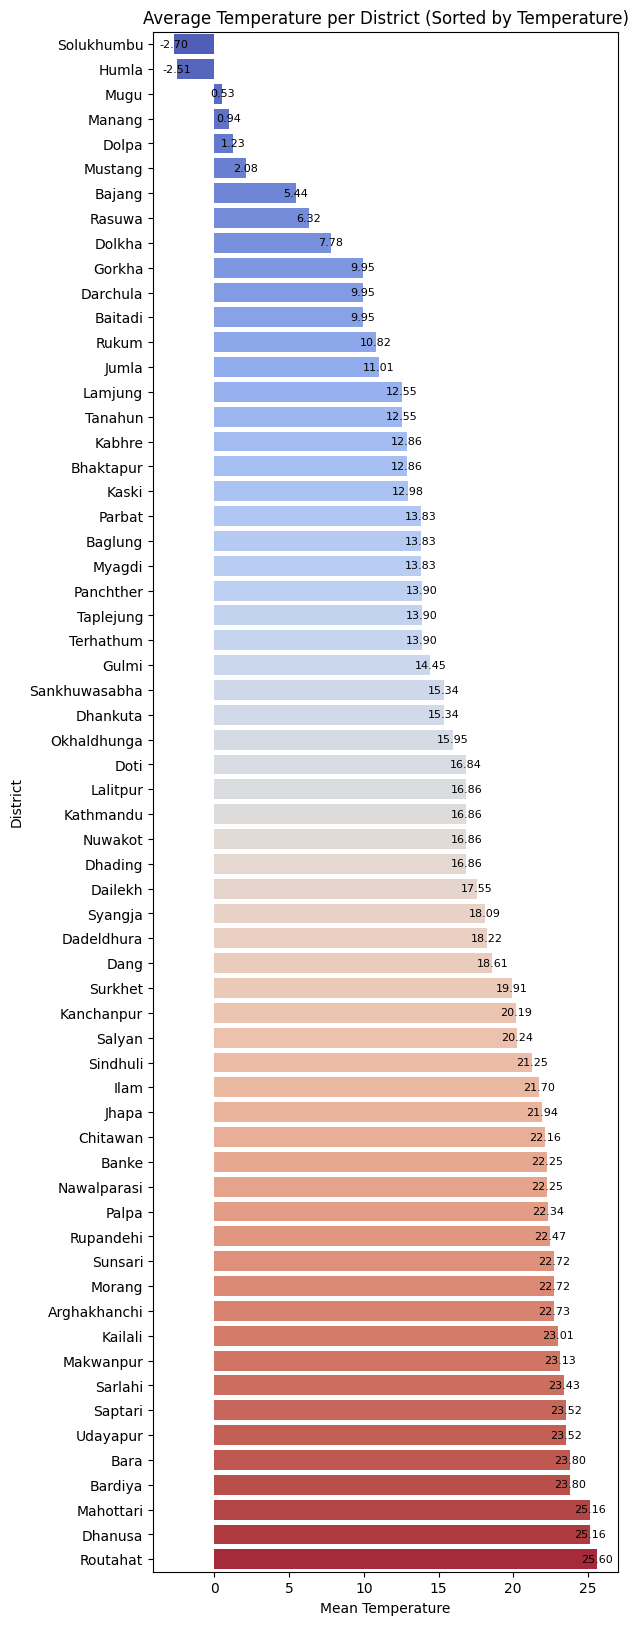

In [12]:
# average temperature for each district
mean_temp = df.groupby('District')['Temp_2m'].mean().sort_values()


plt.figure(figsize=(6, 20))
sns.barplot(x=mean_temp.values, y=mean_temp.index,hue =mean_temp.index ,palette='coolwarm')

for index, value in enumerate(mean_temp.values):
    plt.text(value, index, f'{value:.2f}', color='black', ha='center', va='center',fontsize=8)

plt.title('Average Temperature per District (Sorted by Temperature)')
plt.xlabel('Mean Temperature')
plt.ylabel('District')
plt.show()

### Least rainning to most rainning district

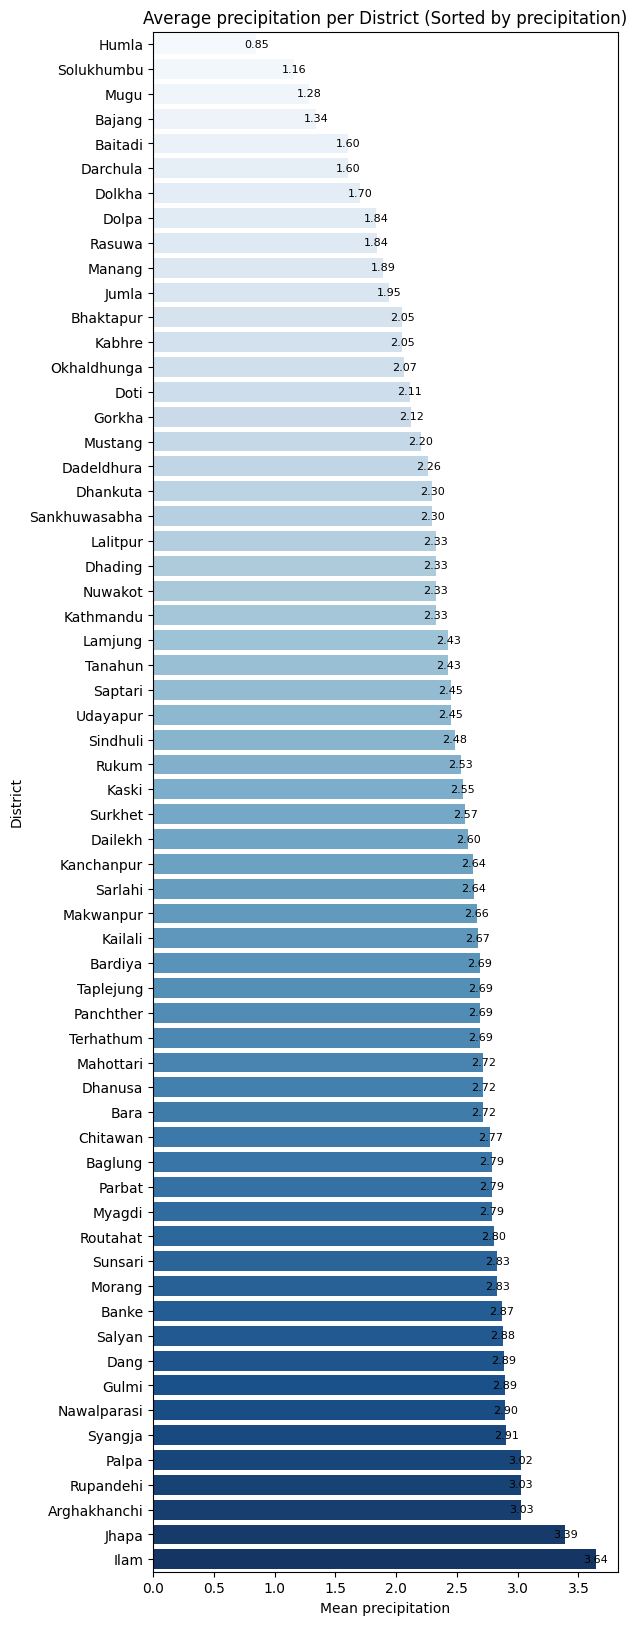

In [13]:

# average precipitation   for each district
mean_prec = df.groupby('District')['Precip'].mean().sort_values()


plt.figure(figsize=(6, 20))
sns.barplot(x=mean_prec.values, y=mean_prec.index, hue=mean_prec.index, palette='Blues')

for index, value in enumerate(mean_prec.values):
    plt.text(value, index, f'{value:.2f}', color='black', ha='center', va='center',fontsize=8)

plt.title('Average precipitation per District (Sorted by precipitation)')
plt.xlabel('Mean precipitation')
plt.ylabel('District')
plt.show()

### Less Humid to More Humid District

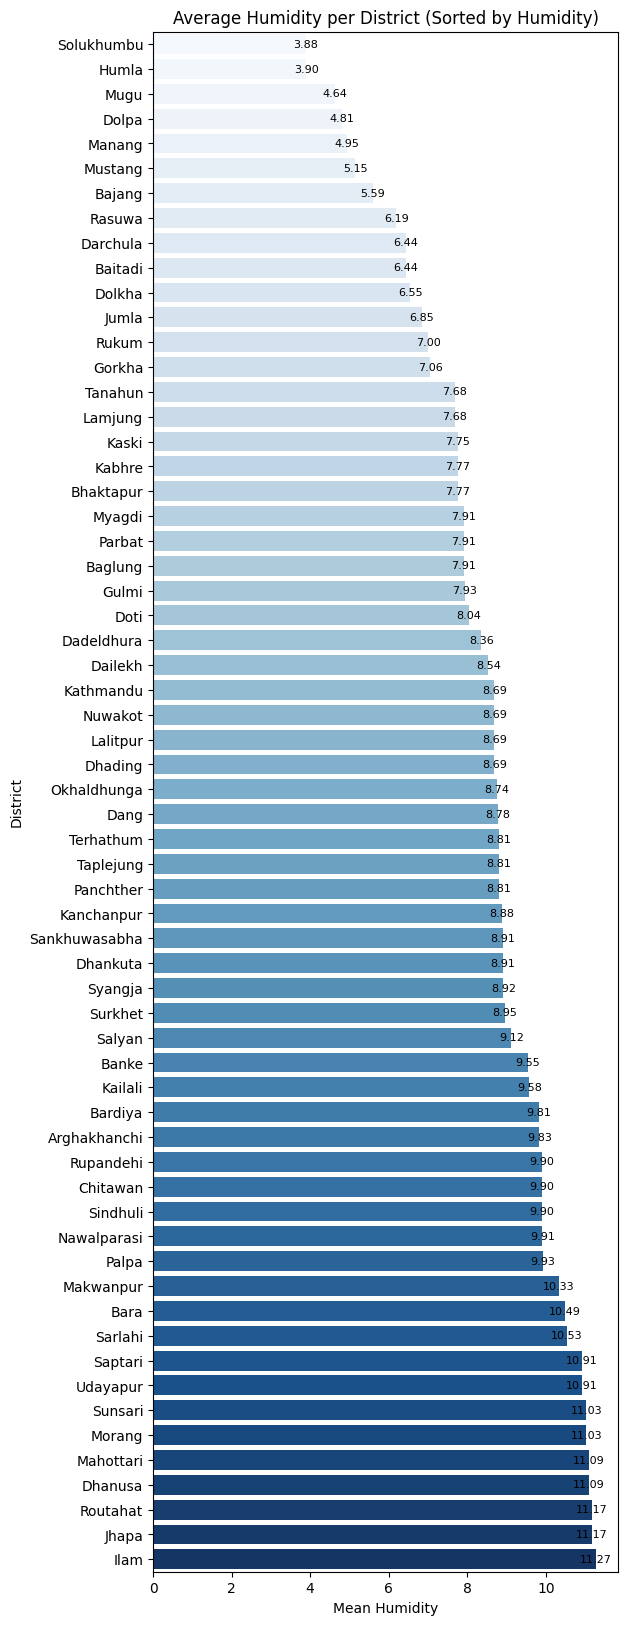

In [14]:
# average Humidity for each district
mean_hu = df.groupby('District')['Humidity_2m'].mean().sort_values()


plt.figure(figsize=(6, 20))
sns.barplot(x=mean_hu.values, y=mean_hu.index, hue=mean_hu.index, palette='Blues')

for index, value in enumerate(mean_hu.values):
    plt.text(value, index, f'{value:.2f}', color='black', ha='center', va='center',fontsize=8)

plt.title('Average Humidity per District (Sorted by Humidity)')
plt.xlabel('Mean Humidity')
plt.ylabel('District')
plt.show()

### Interactive Scatter Plot



In [15]:
def scatter_plot(year):
    df_filtered = df.loc[df.index.year == year]
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='Longitude', y='Latitude',hue='Pressure',palette='coolwarm', data=df_filtered, size='WindSpeed_10m', sizes=(50,400))
    plt.title(f'Geographical Distribution of WindSpeed_10m and Pressure in {year} AD')
    plt.show()

In [17]:
_ = interact(scatter_plot,year = (1981,2019))

interactive(children=(IntSlider(value=2000, description='year', max=2019, min=1981), Output()), _dom_classes=(…

### Visualization of Pressure by District on Map

In [77]:

response = requests.get("https://raw.githubusercontent.com/mesaugat/geoJSON-Nepal/37f73c5cac420447d1d58b51e1a890bb608bf48a/nepal-districts.geojson")

# Check if the request was successful
if response.status_code == 200:
    # Load JSON data
    state_geo = response.json()

    # Print information about the JSON data
    print("Type of state_geo:", type(state_geo))
    print("Keys in state_geo:", state_geo.keys())
    print("Number of features:", len(state_geo["features"]))
    print("Number of type:", len(state_geo["type"]))
    unique_types = set(feature["type"] for feature in state_geo["features"])
    unique_features = set(feature["type"] for feature in state_geo["features"])

    # Print unique names
    print("Unique types:", unique_types)
    print("Unique features:", unique_features)
else:
    print("Failed to fetch data:", response.status_code)



Type of state_geo: <class 'dict'>
Keys in state_geo: dict_keys(['type', 'features'])
Number of features: 75
Number of type: 17
Unique types: {'Feature'}
Unique features: {'Feature'}


In [21]:
df["District"] = df["District"].str.upper()
df.head()

,District,Latitude,Longitude,Precip,Pressure,Humidity_2m,RH_2m,Temp_2m,WetBulbTemp_2m,MaxTemp_2m,...,TempRange_2m,EarthSkinTemp,WindSpeed_10m,MaxWindSpeed_10m,MinWindSpeed_10m,WindSpeedRange_10m,WindSpeed_50m,MaxWindSpeed_50m,MinWindSpeed_50m,WindSpeedRange_50m
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-01,ARGHAKHANCHI,27.9,83.2,0.00,93.51,4.81,45.41,13.89,2.15,20.82,...,10.89,11.32,1.89,3.83,0.69,3.14,2.41,4.12,0.73,3.39
1981-01-02,ARGHAKHANCHI,27.9,83.2,0.00,93.59,4.94,46.78,13.84,2.54,20.70,...,11.17,11.44,1.72,2.60,1.09,1.50,2.25,3.30,0.96,2.34
1981-01-03,ARGHAKHANCHI,27.9,83.2,0.03,93.55,5.22,47.91,14.33,3.32,20.71,...,9.93,12.24,1.80,2.80,0.48,2.32,2.32,3.54,0.39,3.15
1981-01-04,ARGHAKHANCHI,27.9,83.2,0.02,93.49,5.36,50.83,13.82,3.73,20.43,...,10.41,12.17,2.18,3.54,1.06,2.49,2.90,4.05,0.93,3.12
1981-01-05,ARGHAKHANCHI,27.9,83.2,1.84,93.49,5.84,55.55,13.76,4.93,19.62,...,10.53,12.32,1.96,2.70,0.69,2.02,2.74,4.64,0.96,3.68


In [22]:


state_data = df

m = folium.Map(location=[28.1667, 84.25], zoom_start=7)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    columns=['District', 'Pressure'],
    key_on="feature.properties.DISTRICT",
    fill_color="YlGn_r",
    fill_opacity=0.7,
    line_opacity=0.8,
    legend_name="Pressure (hPa)",
).add_to(m)

folium.LayerControl().add_to(m)
m



#### Here we have data only for 62 district, the black color in map show the missing district

### Correlation Matrix

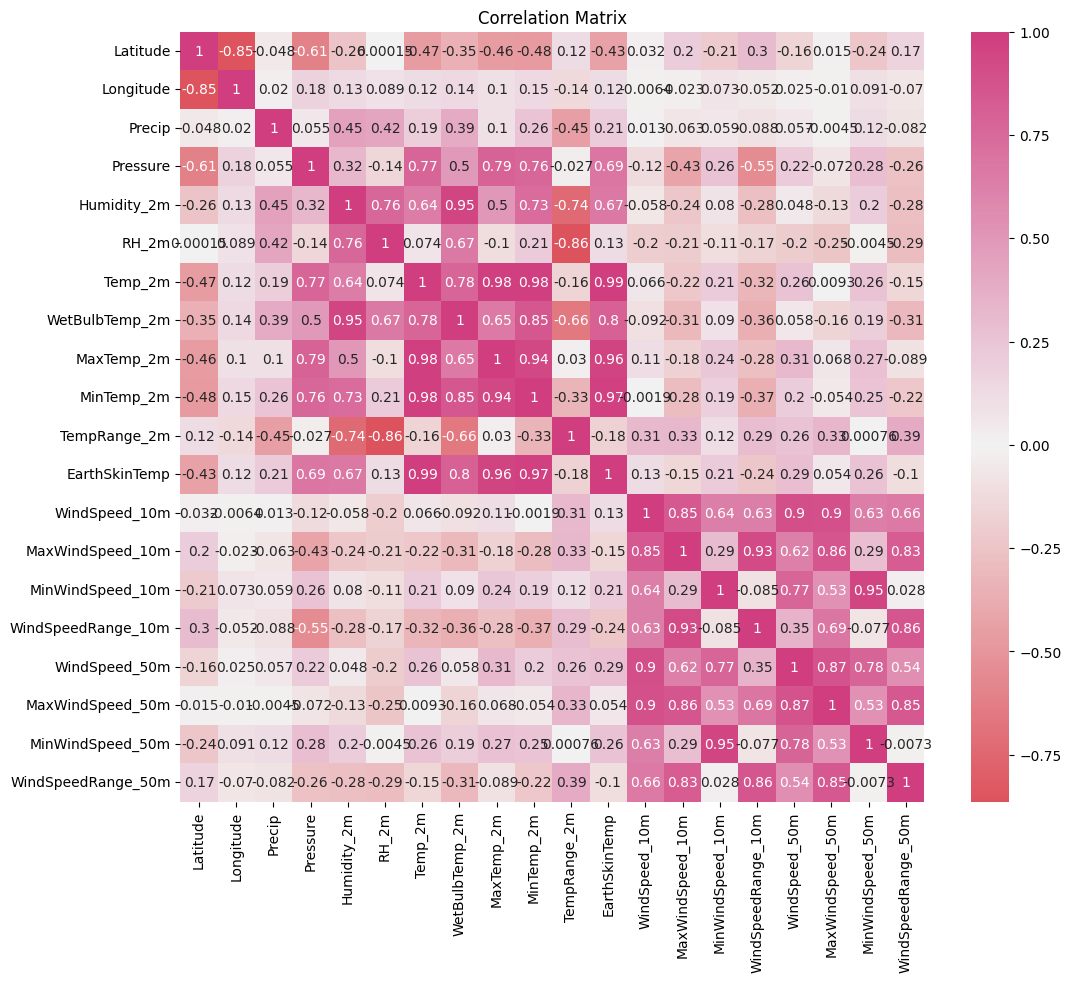

In [23]:
corr_df = df.drop('District', axis=1)
correlation_matrix = corr_df.corr()
# color palette with more distinct colors
cmap = sns.diverging_palette(10, 350, as_cmap=True)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, center=0)
plt.title('Correlation Matrix')
plt.show()

### Wind Speed Analysis

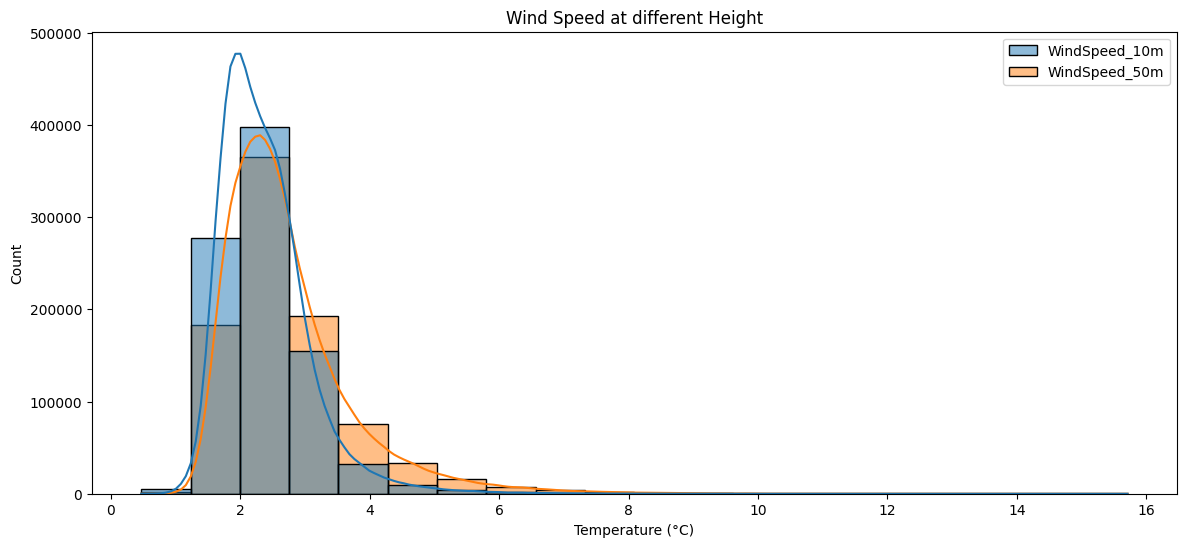

In [32]:
w_columns = ['WindSpeed_10m',
       'WindSpeed_50m',]
plt.figure(figsize=(14, 6))
sns.histplot(df[w_columns], kde=True, bins=20)
plt.title('Wind Speed at different Height')
plt.xlabel('Temperature (°C)')
plt.show()

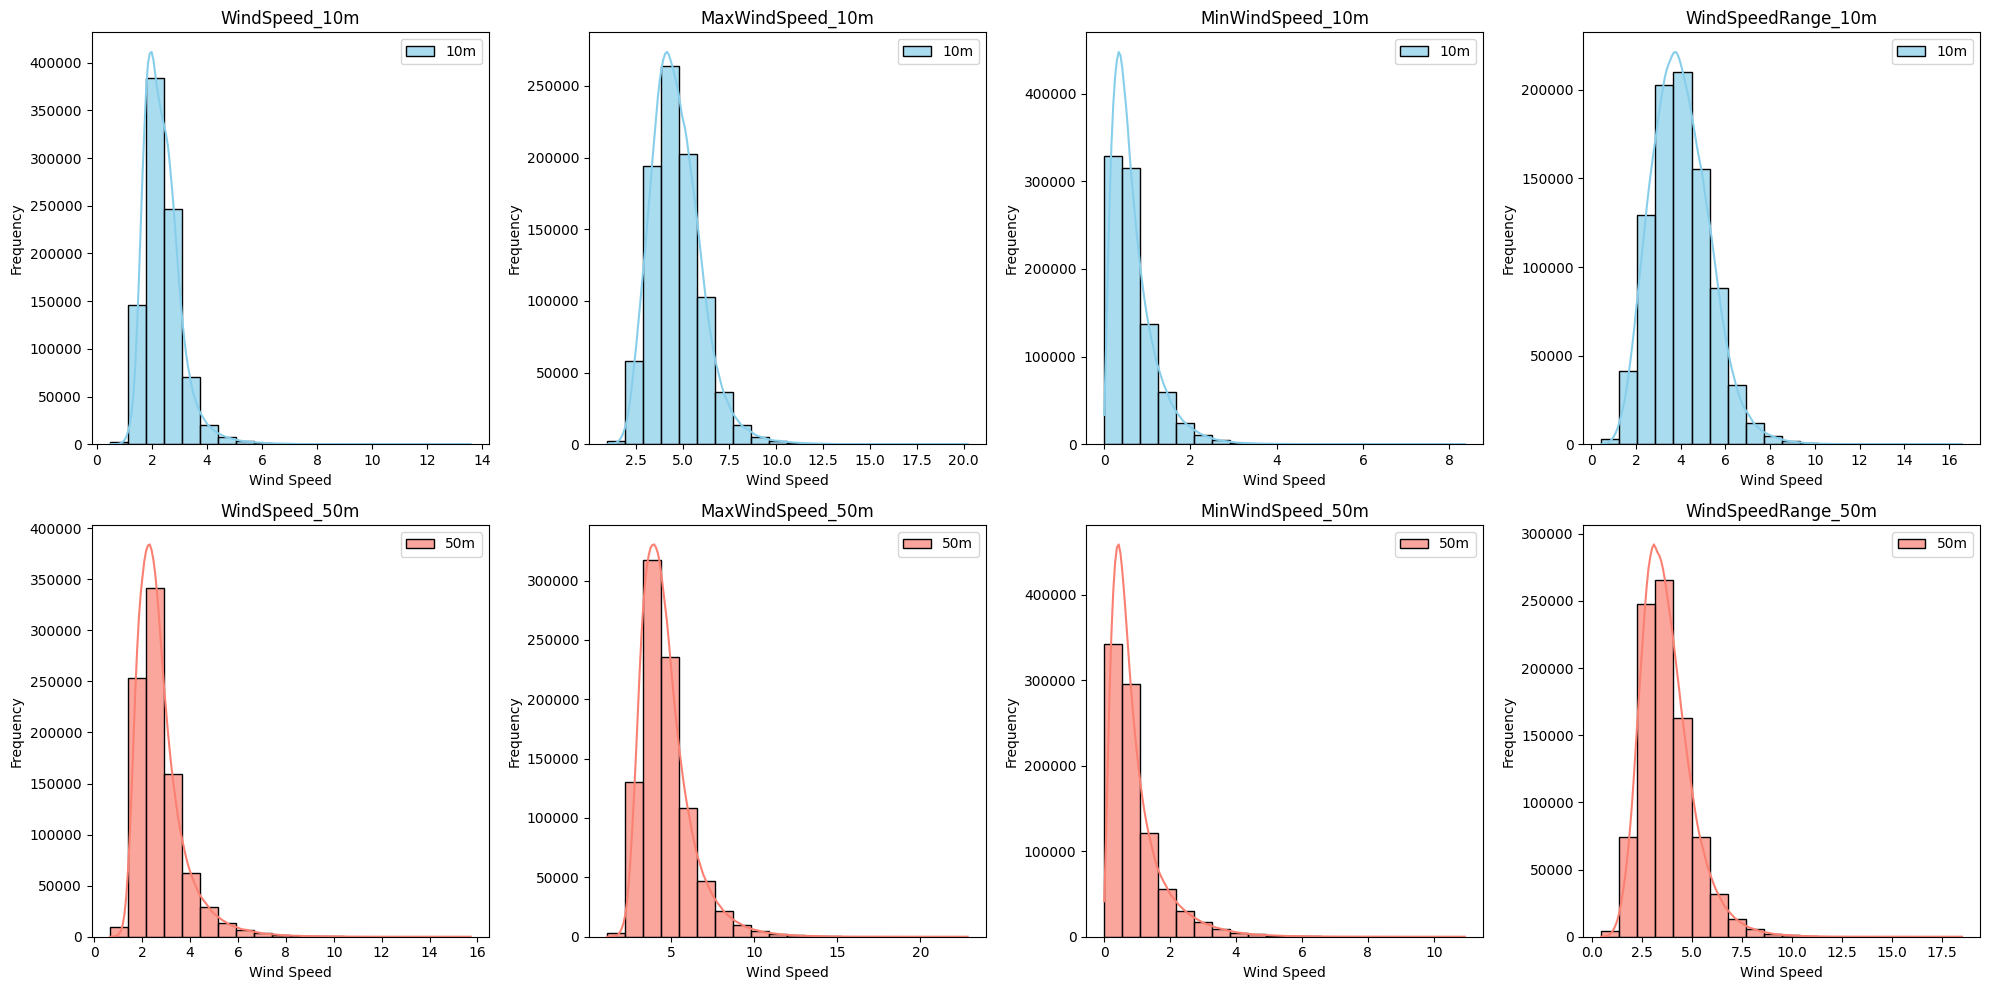

In [33]:
# Selecting relevant wind speed columns
wind_speed_columns_10m = ['WindSpeed_10m', 'MaxWindSpeed_10m', 'MinWindSpeed_10m', 'WindSpeedRange_10m']
wind_speed_columns_50m = ['WindSpeed_50m', 'MaxWindSpeed_50m', 'MinWindSpeed_50m', 'WindSpeedRange_50m']

# Plotting side-by-side histograms for wind speed data at 10m and 50m heights
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))  # Adjust figsize as needed

# Plotting histograms for 10m height
for i, column in enumerate(wind_speed_columns_10m):
    ax = axes[0, i]
    sns.histplot(df[column].dropna(), kde=True, bins=20, color='skyblue', alpha=0.7, label='10m', ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Wind Speed')
    ax.set_ylabel('Frequency')
    ax.legend()

# Plotting histograms for 50m height
for i, column in enumerate(wind_speed_columns_50m):
    ax = axes[1, i]
    sns.histplot(df[column].dropna(), kde=True, bins=20, color='salmon', alpha=0.7, label='50m', ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Wind Speed')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

### Pairplot of Specific parameters

### Different temperature analysis

<ipython-input-43-bb5e3809f85d>:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


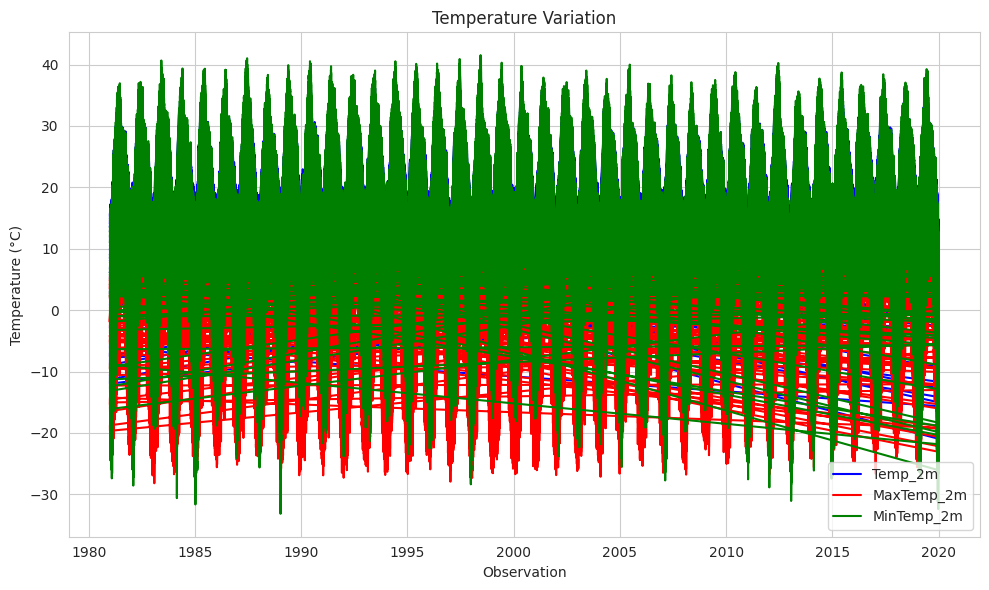

In [43]:
plt.figure(figsize=(10, 6))

plt.plot(df['Temp_2m'], label='Temp_2m', color='blue')
plt.plot(df['WetBulbTemp_2m'], label='MaxTemp_2m', color='red')
plt.plot(df['EarthSkinTemp'], label='MinTemp_2m', color='green')

plt.title('Temperature Variation')
plt.xlabel('Observation')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

### Interactive bar graph of temperature and Precipitation of single district

In [75]:
def d_plot(district):
  district= district.upper()
  d_df = df[df['District']==district]
  if d_df.empty:
    print(f"{district} District Not found")
  else:
    print('Found')
    d_df.loc[:, 'Month'] = d_df.index.month

    # Group data by month and calculate mean for temperature and precipitation
    monthly_mean = d_df.groupby('Month')[['Temp_2m', 'Precip']].mean()

    # Plotting bar plot for temperature and precipitation
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Average Temperature and Precipitation in {district}', fontsize=16)
    # Bar plot for temperature
    plt.subplot(1, 2, 1)
    sns.barplot(x='Month', y='Temp_2m', hue ='Temp_2m', data=monthly_mean, palette='coolwarm')
    plt.title('Average Temperature by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Temperature (°C)')

    # Bar plot for precipitation
    plt.subplot(1, 2, 2)
    sns.barplot(x='Month', y='Precip',hue = 'Precip', data=monthly_mean, palette='Blues')
    plt.title('Average Precipitation by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Precipitation (mm)')

    plt.tight_layout()
    plt.show()

In [76]:
d_c = interact(d_plot, district = 'Rupandehi')

interactive(children=(Text(value='Rupandehi', description='district'), Output()), _dom_classes=('widget-intera…